## A Statistical Analysis predicting whether or not a female patient has diabetes

## **Introduction** 

### Introduction:
Using the Pima Indians Diabetes Data Set, we will use k-means clustering to determine if a fea

#### *Loading the Libraries*

>We will load several packages, such as tidyverse, tidymodels, and set the maximum number of displayed rows to be 6 when we run the console.

In [153]:
#RUN THIS CODE FIRST
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(janitor)
options(repr.matrix.max.rows = 6)

#### *Cleaning and Wrangling the data*

>The diabetes dataset was obtained from Kaggle and is loaded and cleansed. To enhance the data for analysis, excess columns are eliminated, the 'Outcome' variable was first converted from `<dbl>` to `<fct>` using `as_factor` and then to improve the readability of our analysis by renaming "0" to "No" and "1" to "Yes" using `fct_recode`. Lastly column renaming is performed for clarity.

In [154]:
#READING THE DATA
url <- "https://raw.githubusercontent.com/annmariet/project_group_30/main/diabetes.csv"
download.file(url, "diabetes.csv")
diabetes_raw_data <- read_csv("diabetes.csv")

#CLEANING DATA
colnames(diabetes_raw_data) <- c("Pregnancies", "Glucose", "Blood_Pressure", "Skin_Thickness", "Insulin", "BMI", "DBF", "Age", "Outcome")
diabetes_cleaned_data <- diabetes_raw_data |>
    mutate(Outcome = as_factor(Outcome)) |>
    mutate(Outcome = fct_recode(Outcome, "Yes" = "1", "No" = "0"))|>
    select(-Skin_Thickness)
diabetes_cleaned_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,Blood_Pressure,Insulin,BMI,DBF,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,0,33.6,0.627,50,Yes
1,85,66,0,26.6,0.351,31,No
8,183,64,0,23.3,0.672,32,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,112,26.2,0.245,30,No
1,126,60,0,30.1,0.349,47,Yes
1,93,70,0,30.4,0.315,23,No


##### *Table 1: Cleaned and Wrangled data* #####

#### *Splitting the data*

> To ensure reproducibility, the function `set.seed` was used and then we  utilised the `initial_split` function to automatically handle the process of dividing the data. We will specify that `prop` = 0.75, ensuring that 75% of our original dataset is allocated to the training set. Next, assign the `strata` to the Outcome variable in order to ensure that the training and testing subsets have the correct proportions of each observation category.

In [155]:
#SPLITTING DATA
set.seed(4321)
diabetes_split <- diabetes_cleaned_data |>
    initial_split(prop = 0.75, strata = Outcome)

diabetes_train <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)

#### *Summarizing Data*

In [156]:
#SUMMARIZING THE DATA
diabetes_train_summary <- diabetes_train|>
group_by(Outcome)|>
summarize(count = n())
diabetes_train_summary

Outcome,count
<fct>,<int>
No,375
Yes,201


##### *Table 1.1: Summary of number of females that do and do not have diabetes* #####

#### *Calculating means of the predictor variables*

>We used the `collMeans()` function to compute column-wise averages, which allowed us to evaluate the impact of each predictor on diabetes occurrence in females.

In [157]:
Yes_diabetes_mean <- diabetes_train |>
    filter(Outcome == "Yes") |>
    select(-Outcome) |>
    colMeans()

No_diabetes_mean <- diabetes_train |>
    filter(Outcome == "No") |>
    select(-Outcome) |>
    colMeans()

Mean_diabetes_predictors <- rbind(Yes_diabetes_mean, No_diabetes_mean) |>
    as_tibble() |>
    mutate(Outcome = c("yes", "no"))
Mean_diabetes_predictors

Pregnancies,Glucose,Blood_Pressure,Insulin,BMI,DBF,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4.820896,141.4776,69.91045,91.69154,35.35124,0.5544627,37.06965,yes
3.317333,110.4107,68.32267,69.62400,30.31840,0.4330293,31.26933,no


##### *Table 1.2: Means of each predictor variables* #####

The table indicates a link between higher averages of glucose, blood pressure, insulin levels, BMI, DBF, and age and the incidence of diabetes in women. This is consistent with the findings of the National Institute of Diabetes and Digestive and Kidney Diseases, which confirmed that elevated levels of these predictors are associated with a higher risk of diabetes.(Symptoms & Causes of Diabetes - NIDDK, n.d.)

#### *Vizualization*

> Afterwards, we generate histograms for each predictor variable in order to visually represent their distributions within the training dataset.

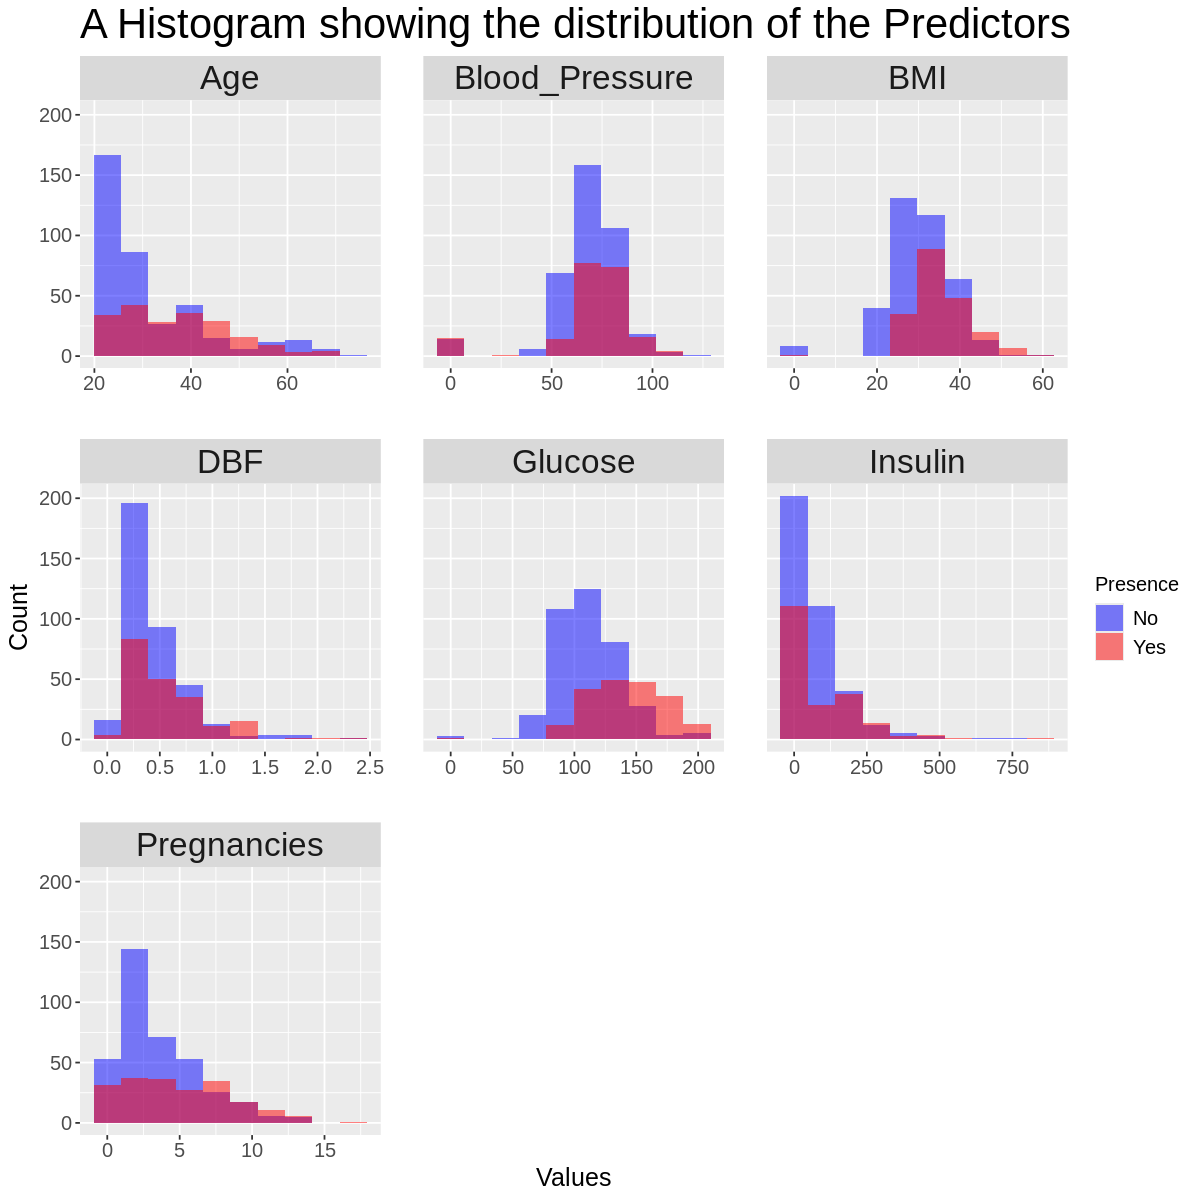

In [158]:
options(repr.plot.height = 10, repr.plot.width = 10)

diabetes_train_long <- diabetes_train |>
    pivot_longer(cols = -Outcome, names_to = "predictors", values_to = "values")

diabetes_train_predictors_plot <- diabetes_train_long |>
    ggplot(aes(values, fill = Outcome)) +
    geom_histogram(bins = 10, alpha = 0.5, position = "identity") +
    facet_wrap(~predictors, scales = "free_x") +
    theme(strip.text.x = element_text(size = 20)) +
    ggtitle("A Histogram showing the distribution of the Predictors") +
    labs(y = "Count", x = "Values", fill = "Presence") +
    scale_fill_manual(values = c("blue", "red")) +
    theme(panel.spacing = unit(0.9, "cm")) +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 12)) +
    theme(plot.title = element_text(size = 25)) +
    theme(legend.title = element_text(size = 12)) +
    theme(legend.text = element_text(size = 12))



diabetes_train_predictors_plot

##### *Graph 1: Histogram showing the distribution of the Predictors* #####

The histograms offer a visual means of comparing important health metrics between individuals who have diabetes and those who do not. There is a noticeable age range in which diabetes is more common. The histograms of blood pressure and BMI demonstrate that individuals diagnosed with diabetes tend to have higher values, highlighting the significance of these factors as risk indicators. The DBF histogram indicates a possible genetic correlation with diabetes. Diabetic individuals exhibit significantly higher levels of glucose and insulin, which are clearly evident and consistent with the characteristics of the disease. Finally, the distribution of pregnancies exhibits variability, which may indicate its impact on the risk of diabetes.

#### *KNN Classification*

>We will utilise the K-Nearest Neighbours (KNN) algorithm to forecast the occurrence of diabetes based on the National Institute of Diabetes and Digestive and Kidney Diseases dataset. We will generate a recipe named `diabetes_recipe` that will rescale and standardise the predictors age, Blood Pressure, BMI, DBF, Glucose, Insulin and Pregnancies of the `diabetes_cleaned_data` dataset. The dataset that has been scaled and centred is saved as `diabetes_scaled`.

In [159]:
diabetes_recipe <- recipe(Outcome ~ Age + Blood_Pressure + BMI + DBF + Glucose + Insulin + Pregnancies, data = diabetes_cleaned_data) |>
         step_scale(all_predictors()) |>
         step_center(all_predictors())

diabetes_scaled <- diabetes_recipe |>
        prep() |> 
        bake(diabetes_cleaned_data)

diabetes_scaled

Age,Blood_Pressure,BMI,DBF,Glucose,Insulin,Pregnancies,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.4250667,0.1495433,0.2038799,0.4681869,0.8477713,-0.6924393,0.6395305,Yes
-0.1905477,-0.1604412,-0.6839762,-0.3648230,-1.1226647,-0.6924393,-0.8443348,No
-0.1055154,-0.2637694,-1.1025370,0.6040037,1.9424580,-0.6924393,1.2330766,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.2755801,0.14954330,-0.7347108,-0.6847471,0.003298721,0.2794117,0.3427574,No
1.1699697,-0.47042568,-0.2400482,-0.3708593,0.159682536,-0.6924393,-0.8443348,Yes
-0.8708064,0.04621514,-0.2019972,-0.4734765,-0.872450641,-0.6924393,-0.8443348,No


##### *Table 1.3: Scaled Diabetes Data* #####

#### *Finding the Best K value*

> The aim is to create a k-nearest neighbours (KNN) classifier that can accurately predict whether patients are suffering diabetes. The first step entails identifying the optimal 'k' value that maximises the precision of the model. We evaluate the model's performance using different 'k' values and generate a graph to illustrate the relationship between model accuracy and 'k'. This visual aid helps us determine the optimal 'k' value that maximises the accuracy of the KNN model.

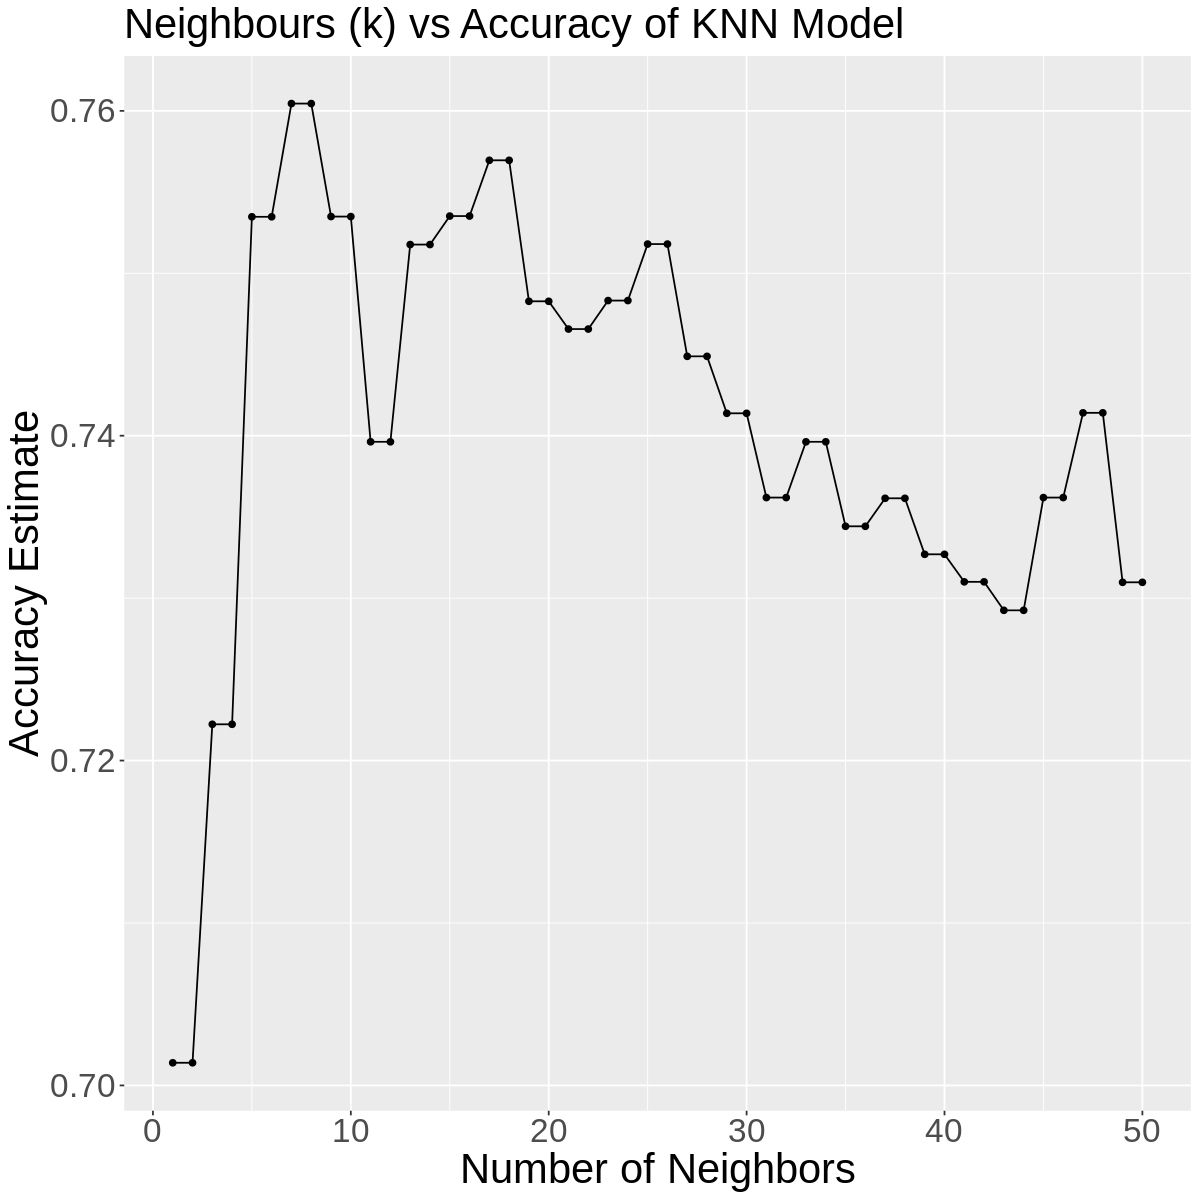

In [160]:
set.seed(4321)
options(repr.matrix.max.rows = 15)

knn_recipe <- recipe(Outcome ~ Age + Blood_Pressure + BMI + DBF + Glucose + Insulin + Pregnancies, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_vfold <- vfold_cv(diabetes_train, v = 5, strata = Outcome)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Neighbours (k) vs Accuracy of KNN Model") +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
    theme(axis.title = element_text(size = 25)) +
    theme(axis.text = element_text(size = 20)) +
    theme(plot.title = element_text(size = 25))

cross_val_plot

##### *Graph 1.1: Accuracy against Number of Neighbors plot to find optimal K* #####

#### *Best K Value*

> By accessing the neighbours variable in the accuracies data frame where the mean variable is highest, we can also get the number of neighbours with the best accuracy through code.

In [161]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

**The value of K at which the mean variable reaches its highest point is 7.**

From the "Finding the best K value" we performed a hyperparameter tuning for KNN classification model using `diabetes_train` dataset.

In order to address the issue of KNN's sensitivity to the scale of predictors, we developed a preprocessing method specifically designed for the `diabetes_train` dataset. This method allows for the standardisation of variables. Using the `vfold_cv()` function from tidymodels, we performed a 5-fold cross-validation, with a tibble specifying a range of 'k' values for evaluation. The `workflow()` function combines the recipe and KNN specifications, `tune_grid()` adjusts the value of 'k' for each fold, and `collect_metrics()` gathers the results. By analysing the accuracy plotted against the number of neighbours, we can determine that selecting k = 7 helps to prevent overfitting in our model.

#### *Max Accuracy Estimate*

In [162]:
accuracies |> summarize(accuracy_estimate = max(mean))

accuracy_estimate
<dbl>
0.7604498


##### *Table 1.4: Results from the max accuracy estimate* #####

#### *Comparing to Majority Classifier*

>The majority classifier always predicts the label of the majority class in the training data, regardless of the values of the predictor variables and will help us compare with our KNN classifier.

In [163]:
diabetes_proportions <- diabetes_train |>
    group_by(Outcome) |>
    summarize(n = n()) |>
    mutate(percent = 100 * n / nrow(diabetes_train))
diabetes_proportions

Outcome,n,percent
<fct>,<int>,<dbl>
No,375,65.10417
Yes,201,34.89583


##### *Table 1.5: Results from the majority classifier* #####

The accuracy achieved by using the majority classifier would be approximately 35%. Our knn-classifier outperforms the majority classifier in terms of accuracy, achieving approximately 76% accuracy.

#### *Testing the model*

In [164]:
set.seed(4321)

knn_spec <- nearest_neighbor(weight = "rectangular", neighbor = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = diabetes_train)

knn_predictions <- predict(knn_fit, diabetes_testing) |>
    bind_cols(diabetes_testing)

knn_metrics <- knn_predictions |>
    metrics(truth = Outcome, estimate = .pred_class)

knn_conf_mat <- knn_predictions |>
    conf_mat(truth = Outcome, estimate = .pred_class)

knn_conf_mat

          Truth
Prediction  No Yes
       No  107  34
       Yes  18  33

##### *Table 1.6: Confusion Matrix* #####

The confusion matrix of our classification model shows 107 instances correctly predicted as negatives and 33 instances correctly predicted as positives, indicating accurate predictions for the absence and presence of the condition, respectively. The data also indicates 34 instances of false positives, where the condition was incorrectly identified, and 18 instances of false negatives, where the model failed to detect the condition. 

#### *Order of Class*

>Precision measures the degree of correctness in the positive predictions made by the model, while recall evaluates the model's capability to identify actual positive cases. Overall accuracy, on the other hand, assesses the model's correct predictions in relation to all cases. Every metric provides a distinct viewpoint on the predictive performance of the model.








In [165]:
diabetes_accuracy <- knn_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")
diabetes_accuracy

diabetes_precision <- knn_predictions |>
    precision(truth = Outcome, estimate = .pred_class, event_level = "second")
diabetes_precision

diabetes_recall <- knn_predictions |>
    recall(truth = Outcome, estimate = .pred_class, event_level = "second")
diabetes_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7291667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6470588


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4925373


The accuracy of our classifier was calculated at 72.9%, whereas the precision was calculated at 64.7% and the recall was calculated at 49.3%

# *Refrences*

- Pima Indians Diabetes Database. (n.d.). Kaggle. Retrieved March 9, 2024, from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
- What is diabetes? | CDC. (n.d.). Centers for Disease Control and Prevention. Retrieved March 9, 2024, from https://www.cdc.gov/diabetes/basics/diabetes.html
- Your tea habit may fight this common disease. (2017, November 9). medium. Retrieved March 9, 2024, from https://medium.com/beingwell/your-tea-habit-may-fight-this-common-disease-25ef001d13f7
- Symptoms & Causes of Diabetes - NIDDK. (n.d.). National Institute of Diabetes and Digestive and Kidney Diseases. Retrieved April 12, 2024, from https://www.niddk.nih.gov/health-information/diabetes/overview/symptoms-causes
